In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from notebooks.config import ModelType, TRAINING_DIRECTORY, SPLIT_DIRECTORY, FEATURES_DIRECTORY, IMAGES_DIRECTORY, EMBEDDING_DIM, UNITS, VOCABULARY_SIZE, BATCH_SIZE, EPOCHS, END_TOKEN, START_TOKEN
from notebooks.utils import latest_file, logger
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
import matplotlib.pyplot as plt
from PIL import Image
import random
import warnings

2024-05-22 07:40:13.044758: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 07:40:13.252335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 07:40:13.252372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 07:40:13.297786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 07:40:13.454973: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.__version__

'2.15.1'

In [31]:
warnings.filterwarnings("ignore")

logger = logger()
THREAD_NUMBER = 8
model_type = ModelType.INCEPTION_RES_NET_V2
PATH_TO_FEATURES = os.path.join(FEATURES_DIRECTORY, model_type.name)

optimizer = Adam()
loss_func = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

TRAINING_DIRECTORY = os.path.join(TRAINING_DIRECTORY, model_type.name)
if not os.path.exists(TRAINING_DIRECTORY):
    os.makedirs(TRAINING_DIRECTORY)

In [32]:
class BahdanauAttention(Model):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))
        
        score = self.V(attention_hidden_layer)
        
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Encoder(Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, memory_state, carry_state = self.lstm(x)

        x = self.fc1(output)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, memory_state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [33]:
with open(latest_file(SPLIT_DIRECTORY, 'tokenizer'), 'rb') as handle:
    tokenizer: Tokenizer = pickle.load(handle)

END_TOKEN_INDEX = tokenizer.word_index.get(END_TOKEN)
START_TOKEN_INDEX = tokenizer.word_index.get(START_TOKEN)

train = np.load(latest_file(SPLIT_DIRECTORY, 'train'))
test = np.load(latest_file(SPLIT_DIRECTORY, 'test'))
val = np.load(latest_file(SPLIT_DIRECTORY, 'val'))

captions_train = pad_sequences(tokenizer.texts_to_sequences(train[:, 1]), padding='post')
captions_test = pad_sequences(tokenizer.texts_to_sequences(test[:, 1]), padding='post')
captions_validation = pad_sequences(tokenizer.texts_to_sequences(val[:, 1]), padding='post')

MAX_LEN = len(captions_train[0])

indexes_train = [i for i in range(len(train))]
file_names_train = [os.path.join(PATH_TO_FEATURES, i + '.npy') for i in train[:, 0]]

indexes_test = [i for i in range(len(test))]
file_names_test = [os.path.join(PATH_TO_FEATURES, i + '.npy') for i in test[:, 0]]

indexes_val = [i for i in range(len(val))]
file_names_val = [os.path.join(PATH_TO_FEATURES, i + '.npy') for i in val[:, 0]]

def load_data(i, image, captions):
    return np.load(image), captions[i]

def load_test_data(i, image):
    return np.load(image), captions_test[i]

def load_train_data(i, image):
    return np.load(image), captions_train[i]

def load_validation_data(i, image):
    return np.load(image), captions_validation[i]

def decode_captions(caption):
    sentence = ''
    for i in caption:
        if i == END_TOKEN_INDEX:
            return sentence
        sentence += tokenizer.index_word.get(i) + ' '
    return sentence

train_dataset = (tf.data.Dataset.from_tensor_slices((indexes_train, file_names_train))
           .map(lambda item1, item2: tf.numpy_function(load_train_data, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((indexes_test, file_names_test))
           .map(lambda item1, item2: tf.numpy_function(load_test_data, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

validation_dataset = (tf.data.Dataset.from_tensor_slices((indexes_val, file_names_val))
           .map(lambda item1, item2: tf.numpy_function(load_validation_data, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

ModuleNotFoundError: No module named 'keras.src.legacy'

In [ ]:
class Metric:
    def __init__(self):
        super(Metric, self).__init__()
        self.score = 0
        self.count = 0
        self.scorer = self.scorer()

    def scorer(self):
        pass
    
    def name(self):
        pass
    
    def str_result(self):
        return self.name() + ': ' + str(self.result())
    
    def get_score(self, true, pred):
        return self.scorer.compute_score({1: [true]}, {1: [pred]})[0]
    
    def update_state(self, y_true, y_pred):
        for true, pred in zip(y_true, y_pred):
            self.score += self.get_score(true, pred)
            self.count += 1
    
    def result(self):
        return np.divide(self.score, self.count)

    def reset_state(self):
        self.score = 0
        self.count = 0
          
class BLEU(Metric):
    def scorer(self):
        return Bleu(1)
    
    def name(self):
        return 'BLEU'
    
    def get_score(self, true, pred):
        return super().get_score(true, pred)[0]

class METEOR(Metric):
    def scorer(self):
        return Meteor()
    
    def name(self):
        return 'METEOR'

class ROUGE(Metric):
    def scorer(self):
        return Rouge()
    
    def name(self):
        return 'ROUGE'

class CIDER(Metric):
    def scorer(self):
        return Cider()
    
    def name(self):
        return 'CIDER'

class SPICE(Metric):
    def scorer(self):
        return Spice()
    
    def name(self):
        return 'SPICE'

In [ ]:
encoder = Encoder(EMBEDDING_DIM)
decoder = Decoder(EMBEDDING_DIM, UNITS, VOCABULARY_SIZE)

metrics = [BLEU(), METEOR(), ROUGE()]

history = {'loss': [], 'loss_val': []}
for metric in metrics:
    history[metric.name()] = []
    history[metric.name() + '_val'] = []

num_steps_train = len(train) // BATCH_SIZE
num_steps_validation = len(val) // BATCH_SIZE

first_epoch = 0

files = [f.split('.')[0].split('_')[1] for f in os.listdir(TRAINING_DIRECTORY)]
if len(files) > 0:
    first_epoch = max([int(f) for f in files])
    encoder(tf.zeros((BATCH_SIZE, 25, 1536)))
    decoder(tf.zeros((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 25, EMBEDDING_DIM)), tf.zeros((BATCH_SIZE, UNITS)))
    encoder.load_weights(os.path.join(TRAINING_DIRECTORY, 'encoder_' + str(first_epoch) + '.weights.h5'))
    decoder.load_weights(os.path.join(TRAINING_DIRECTORY, 'decoder_' + str(first_epoch) + '.weights.h5'))
    with open(os.path.join(TRAINING_DIRECTORY, 'history_0.pkl'), 'rb') as file:
        history = pickle.load(file)
    logger.info("Training is starting from " + str(first_epoch + 1) + " epoch")

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_func(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)  

@tf.function
def train_function(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([START_TOKEN_INDEX] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

@tf.function
def validation_function(img_tensor, target):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([START_TOKEN_INDEX] * target.shape[0], 1)
    
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        dec_input = tf.expand_dims(target[:, i], 1)
    
    total_loss = (loss / int(target.shape[1]))
    
    return loss, total_loss

def evaluation(img_tensor, target):
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([START_TOKEN_INDEX] * target.shape[0], 1)
    
    features = encoder(img_tensor)
    decoded_predictions = tf.zeros((target.shape[0], 0), dtype=tf.int64)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        indexes = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(indexes, 1)
        decoded_predictions = tf.concat([decoded_predictions, dec_input], axis=1)
    
    true = [decode_captions(i)[:-1] for i in np.delete(target.numpy(), 0, axis=1)]
    pred = [decode_captions(i)[:-1] for i in decoded_predictions.numpy()]

    for metric in metrics:
        metric.update_state(true, pred)

def get_prediction(img):
    
    img = np.expand_dims(img, axis=0)
    
    hidden = decoder.reset_state(batch_size=BATCH_SIZE)
    dec_input = tf.expand_dims([START_TOKEN_INDEX] * BATCH_SIZE, 1)
    
    features = encoder(img)
    decoded_predictions = tf.zeros((BATCH_SIZE, 0), dtype=tf.int64)
    for i in range(1, MAX_LEN):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        indexes = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(indexes, 1)
        decoded_predictions = tf.concat([decoded_predictions, dec_input], axis=1)
    
    pred = [decode_captions(i)[:-1] for i in decoded_predictions.numpy()]

    return pred[0]

In [6]:
BATCH_SIZE = 1

def evaluate(image):
   attention_plot = np.zeros((MAX_LEN, 30))

   hidden = decoder.reset_state(batch_size=BATCH_SIZE)
   img_tensor_val = np.load(image)

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([START_TOKEN_INDEX] * BATCH_SIZE, 1)
   result = []

   for i in range(MAX_LEN):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       predicted_id = tf.argmax(predictions[0]).numpy()

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       result.append(tokenizer.index_word[predicted_id])
       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   if len(result) % 2 == 1:
       result.append('')
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

import os
from config import FEATURES_DIRECTORY
image = os.path.join(FEATURES_DIRECTORY, 'INCEPTION_RES_NET_V2', '909244.npy')

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print(result)
plot_attention(os.path.join(IMAGES_DIRECTORY, '909244.jpg'), result, attention_plot)

NameError: name 'MAX_LEN' is not defined

In [18]:
for metric in metrics:
        metric.reset_state()

for batch, (img_tensor, target) in enumerate(test_dataset):
        evaluation(img_tensor, target)
        
        result = ''
        for metric in metrics:
            result += metric.str_result() + ' '
        
        if batch % 100 == 0 and batch != 0:
            logger.info('VAL Batch {} Metrics {}'.format(batch, result))
            print(str(m.result()) for m in metrics)

NameError: name 'test_dataset' is not defined

In [9]:
for metric in metrics:
      print(metric.name(), metric.result())

BLEU 0.1446128954420251
METEOR 0.06984458190571277
ROUGE 0.18062386229822436


In [9]:
for epoch in range(first_epoch, EPOCHS):
    total_loss_train, total_loss_validation = 0, 0
            
    for metric in metrics:
        metric.reset_state()

    for batch, (img_tensor, target) in enumerate(train_dataset):
        batch_loss, t_loss = train_function(img_tensor, target)
        total_loss_train += t_loss

        if batch % 100 == 0 and batch != 0:
            logger.info('TRAIN Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            
    for batch, (img_tensor, target) in enumerate(train_dataset):
        evaluation(img_tensor, target)
        
        result = ''
        for metric in metrics:
            result += metric.str_result() + ' '
        
        if batch % 100 == 0 and batch != 0:
            logger.info('TRAIN Epoch {} Batch {} Metrics {}'.format(epoch + 1, batch, result))
    
    for metric in metrics:
        history[metric.name()].append(metric.result())
    
    logger.info('---Validation---')
    for batch, (img_tensor, target) in enumerate(validation_dataset):
        batch_loss, t_loss = validation_function(img_tensor, target)
        total_loss_validation += t_loss

        if batch % 100 == 0 and batch != 0:
            logger.info('VAL Epoch {} Batch {} Validation Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    for metric in metrics:
        metric.reset_state()
        
    for batch, (img_tensor, target) in enumerate(validation_dataset):
        evaluation(img_tensor, target)
        
        result = ''
        for metric in metrics:
            result += metric.str_result() + ' '
        
        if batch % 100 == 0 and batch != 0:
            logger.info('VAL Epoch {} Batch {} Metrics {}'.format(epoch + 1, batch, result))
    
    history['loss'].append((total_loss_train / num_steps_train).numpy())
    history['loss_val'].append((total_loss_validation / num_steps_validation).numpy())
    
    for metric in metrics:
        history[metric.name() + '_val'].append(metric.result())

    logger.info('Epoch {} Loss {:.6f} Validation Loss {:.6f}'.format(epoch + 1, total_loss_train / num_steps_train, total_loss_validation / num_steps_validation))
    path = os.path.join(TRAINING_DIRECTORY, '{}_' + str(epoch + 1) + '.{}')
    logger.info("Saving weights into " + path.format("*", "h5") + "\n")
    # encoder.save_weights(path.format("encoder", "weights.h5"))
    # decoder.save_weights(path.format("decoder", "weights.h5"))
    # with open(os.path.join(TRAINING_DIRECTORY, 'history_0.pkl'), 'wb') as file:
    #     pickle.dump(history, file)
    break


KeyboardInterrupt



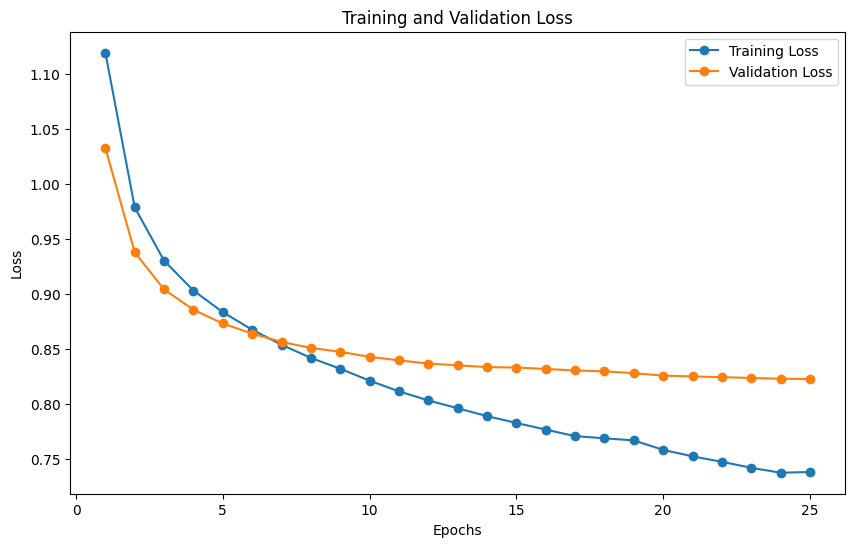

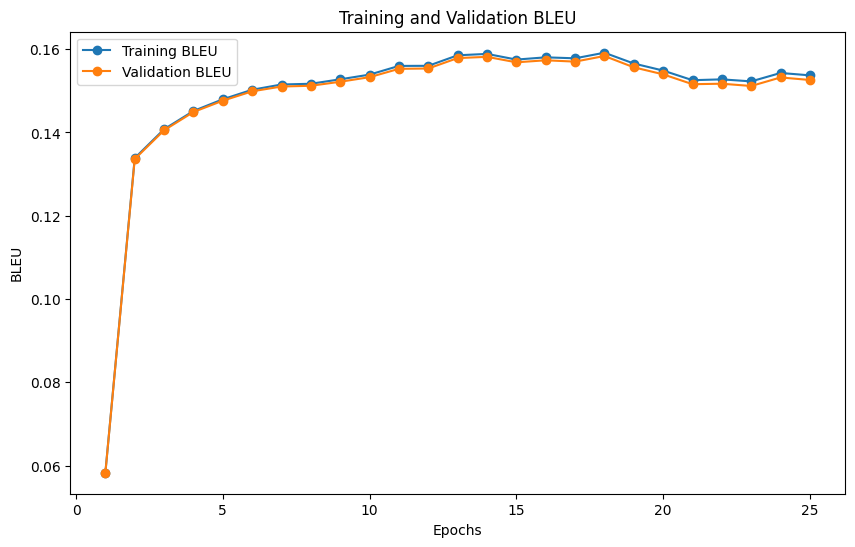

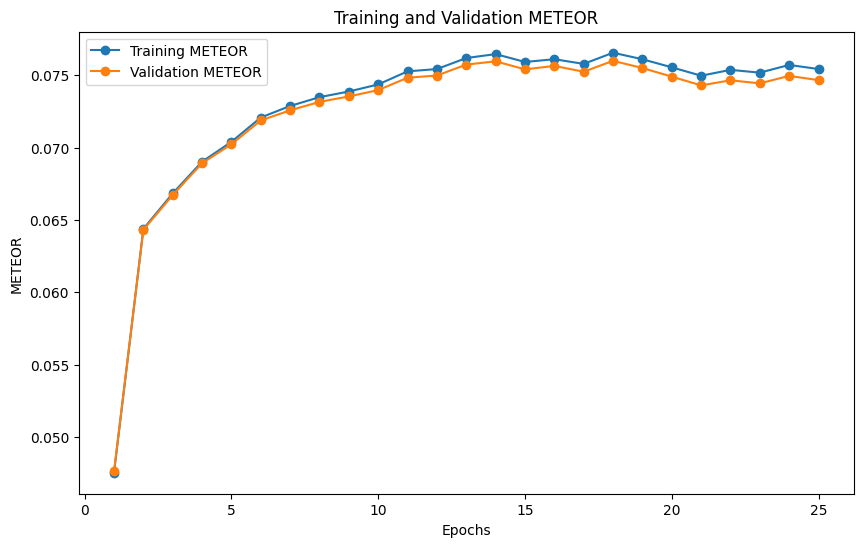

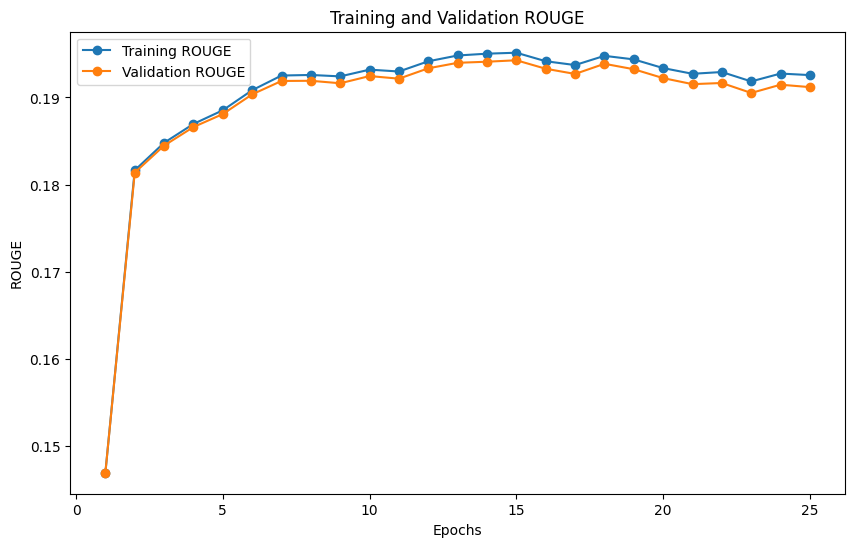

In [8]:
def plot(train_data, validation_data, name):
    epochs = [i + 1 for i in range(len(train_data))]
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_data, label='Training ' + name, marker='o')
    plt.plot(epochs, validation_data, label='Validation ' + name, marker='o')
    
    plt.title('Training and Validation ' + name)
    plt.xlabel('Epochs')
    plt.ylabel(name)

    plt.legend()
    plt.show()

plot(history['loss'], history['loss_val'], 'Loss')
plot(history['BLEU'], history['BLEU_val'], 'BLEU')  
plot(history['METEOR'], history['METEOR_val'], 'METEOR')
plot(history['ROUGE'], history['ROUGE_val'], 'ROUGE')

In [ ]:
def predict(id):
    test_element = test[np.where(test[:, 0] == str(str(id)))][0]
    image = Image.open(os.path.join(IMAGES_DIRECTORY, test_element[0] + '.jpg'))
    display(image)

    print('Original Caption: ' + test_element[1][len(START_TOKEN):-len(END_TOKEN)])
    print('Predicted Caption: ' + get_prediction(np.load(os.path.join(PATH_TO_FEATURES, test_element[0] + '.npy'))))
    print()

In [ ]:
for i in [135625, 1116207, 248776, 1545027, 1509577, 1768881, 473737, 1240198, 486329, 1982839, 200335, 1249789]:
    predict(i)

In [ ]:
from config import FILTERED_DATASET_DIRECTORY
import pandas as pd

path_to_dataset = latest_file(FILTERED_DATASET_DIRECTORY)
dataset = pd.read_csv(path_to_dataset, sep='\t', index_col=0, header=None)

In [ ]:
 print(dataset.loc[1076014][1])

In [14]:
print(len(val))

18433


In [10]:
print(history)

{'loss': [1.1189734, 0.978501, 0.93020684, 0.9031165, 0.88343227, 0.86753327, 0.8538879, 0.8419562, 0.83208126, 0.821312, 0.8115885, 0.8033753, 0.796232, 0.78913665, 0.78290254, 0.7768769, 0.77090096, 0.7689717, 0.7670517, 0.7584734, 0.75257957, 0.74762183, 0.742211, 0.73771787, 0.7383698], 'loss_val': [1.0325275309513278, 0.9377511730832404, 0.9041063449215414, 0.8856571327073066, 0.8731880347256179, 0.8640060577480473, 0.8564675055891714, 0.8510506074723649, 0.8474424560293576, 0.842949153797723, 0.8397103461343693, 0.8368554091715069, 0.835195148847814, 0.8336159345320233, 0.8331786661891418, 0.8319440142281096, 0.8305265468385812, 0.8297492933593629, 0.8280607733486212, 0.8259039889858433, 0.8251068669139243, 0.824473324821073, 0.8237154430160445, 0.8230228382851135, 0.8227227308119591], 'BLEU': [0.05833520699630901, 0.13384207740067033, 0.14077413293062335, 0.14514759952165657, 0.14796391163034467, 0.15024840566979286, 0.1515094577162786, 0.15168959556852263, 0.15275743375465434, 

In [14]:
!python3 -m pip install --upgrade pip
!pip install --upgrade keras

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Defaulting to user installation because normal site-packages is not writeable


In [22]:
import keras
import tensorflow
tensorflow.__version__

'2.16.1'

In [15]:
!python3 -m pip install tensorflow[and-cuda]

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Defaulting to user installation because normal site-packages is not writeable


In [18]:
!pip install keras==2.15.0

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Defaulting to user installation because normal site-packages is not writeable
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
